Goal: evaluate transfer learning approach, i.e. first training a single-task model on a cell type with abundant high quality data and then fine tuning on a cell time with less data.

Single-task transfer learning model
 - Pre-train single-task model on Stromal data
 - Fine-tune on downsampled PT data
 
Single-task base model
 - Train single-task model on downsampled PT

In [2]:
%%bash

# process downsampled PT data
scripts_dir="/clusterfs/nilah/pooja/batch_scripts/preprocess"
targets="1272_cells_downsampled_PT"

cp ${scripts_dir}/preprocess_mouse_models_template.sh ${scripts_dir}/preprocess_${targets}.sh
echo "python /global/home/users/poojakathail/basenji/bin/basenji_data.py -b /clusterfs/nilah/pooja/genomes/hg38.blacklist.rep.bed -g /clusterfs/nilah/pooja/genomes/hg38_gaps.bed -p 20 -r 4096 -w 192 -l 1344 -v "chr7,chr14,chr15" -t "chr4,chr5" --stride 192 --stride_test 192 --crop 576 -o /clusterfs/nilah/pooja/kidney_data/downsampled_bigwigs/processed/${targets} --local /clusterfs/nilah/pooja/genomes/hg38.ml.fa /clusterfs/nilah/pooja/kidney_data/targets/kidney_sc_wigs_hg38_${targets}.txt" >> ${scripts_dir}/preprocess_${targets}.sh
sbatch ${scripts_dir}/preprocess_${targets}.sh

Submitted batch job 16776792


In [1]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/train"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_single_task_multi_gpu.json"
data_dir="/clusterfs/nilah/pooja/kidney_data/downsampled_bigwigs/processed/1272_cells_downsampled_PT"

# Train single-task model on downsampled PT
cp ${script_dir}/train_multi_gpu_template.sh ${script_dir}/train_single_task_downsampled_PT.sh
echo "python /global/home/users/poojakathail/basenji/bin/basenji_train.py -k -o /clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__single_task__downsampled_PT__all_sequences__1/done.txt --float-type float32 ${params} ${data_dir}" >> ${script_dir}/train_single_task_downsampled_PT.sh
sbatch ${script_dir}/train_single_task_downsampled_PT.sh

# Fine-tune Stromal pre-trained single-task model on downsampled PT
cp ${script_dir}/train_multi_gpu_template.sh ${script_dir}/train_transfer_single_task_downsampled_PT.sh
echo "python /global/home/users/poojakathail/basenji/bin/basenji_train.py -k --restore /clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__single_task__Str__all_sequences__1/model_best.h5 -o /clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__single_task__pretrain_Str_downsampled_PT__all_sequences__1/done.txt --float-type float32 ${params} ${data_dir}" >> ${script_dir}/train_transfer_single_task_downsampled_PT.sh
sbatch ${script_dir}/train_transfer_single_task_downsampled_PT.sh


Submitted batch job 16777742


In [2]:
%%bash

script_dir="/clusterfs/nilah/pooja/batch_scripts/train"
cluster_dir="/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11"
cluster_list="all_sequences,cluster1_CD,cluster2_Immune,cluster3_Ubiquitous,cluster4_DistalNephron,cluster6_PanTubule,cluster7_Tcell,cluster8_PanNonEpithelial,cluster9_Stroma,cluster10_Endothelial,cluster11_PT,cluster12_podocyte"
genome="hg38"
targets="/clusterfs/nilah/pooja/kidney_data/targets/kidney_sc_wigs_hg38_1272_cells_downsampled_PT.txt"
model_params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_single_task.json"


for model in single_task__downsampled_PT__all_sequences__1 single_task__pretrain_Str_downsampled_PT__all_sequences__1;
do
    model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__${model}"
    cp ${script_dir}/train_immune_atlas_single_task_template.sh ${script_dir}/test_kidney_data_${model}.sh
    echo "/global/home/users/poojakathail/basenji/bin/basenji_predict_cluster_beds.sh $cluster_dir $cluster_list $genome $targets $model_params ${model_dir}/done.txt ${model_dir}/predict_beds/done_predict_beds.txt" >> ${script_dir}/test_kidney_data_${model}.sh
    echo "python /global/home/users/poojakathail/basenji/bin/basenji_reference_accuracy_by_cluster.py -t $targets ${model_dir}/predict_beds/reference_accuracy_by_cluster.tsv ${cluster_dir}/model_predictions" >> ${script_dir}/test_kidney_data_${model}.sh
    sbatch ${script_dir}/test_kidney_data_${model}.sh
done

Submitted batch job 16811330
Submitted batch job 16811331


### Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.evaluate_basset_performance import *

In [3]:
data_dir = "/clusterfs/nilah/pooja/kidney_data"
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures"

targets = pd.read_csv(f"{data_dir}/targets.txt", sep="\t", header=0, index_col=0)
cell_type_peak_set_mapping = {"downsampled_PT": ["cluster11_PT", "cluster3_Ubiquitous", "all_sequences"],
                              "pretrain_Str_downsampled_PT": ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"]}


tasks = ["single_task"]
training_sets = ["all_sequences"]
cell_types = ["downsampled_PT", "pretrain_Str_downsampled_PT"]

In [5]:
# reference accuracy
ref_acc_by_cluster_replicates = read_reference_accuracy_replicates(data_dir, cell_types, 
                                                                   tasks, training_sets)
ref_acc_by_cluster_replicates["single_task"]["all_sequences"][0].columns = cell_types

formatted_df = format_df_to_plot(ref_acc_by_cluster_replicates, cell_type_peak_set_mapping,
                                 tasks, training_sets)
formatted_df.loc[~formatted_df["Cluster"].isin(['cluster3_Ubiquitous', 'all_sequences']), 
                 "Cluster"] = "Cell-type specific"

formatted_df.loc[formatted_df["Cell Type"] == "downsampled_PT", "Training Task"] = "Trained from scratch on downsampled PT data"
formatted_df.loc[formatted_df["Cell Type"] == "pretrain_Str_downsampled_PT", "Training Task"] = "Pretrained on Stromal data and\nfinetuned on downsampled PT data"
formatted_df["Cell Type"] = "PT"

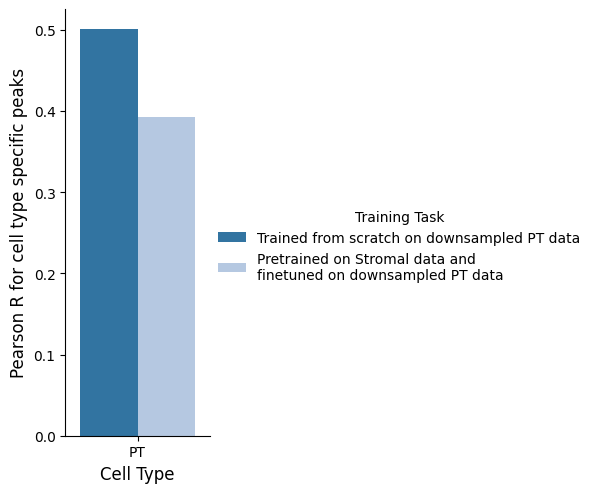

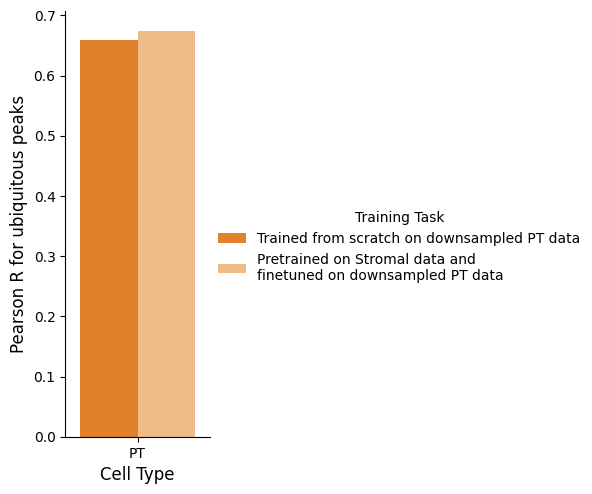

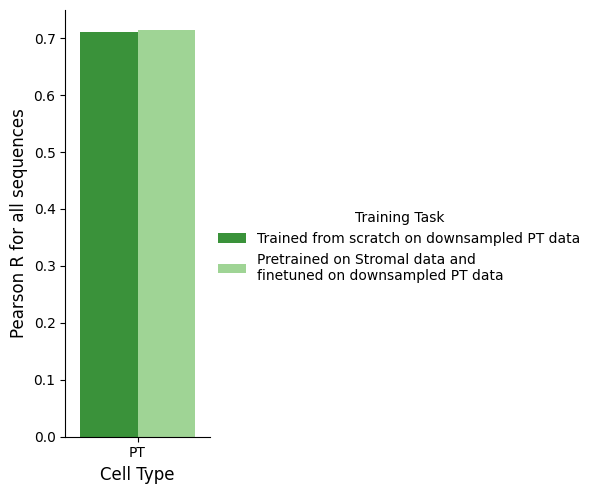

In [9]:
cmap = plt.get_cmap("tab20")
cluster_labels = ["cell type specific peaks", "ubiquitous peaks", "all sequences"]
for i, cluster in enumerate(["Cell-type specific",  "cluster3_Ubiquitous", "all_sequences"]):
    sns.catplot(data=formatted_df[(formatted_df["Training Data"] == "all_sequences") &
                                  (formatted_df["Cluster"] == cluster)],
                x="Cell Type", y="Pearson R", hue="Training Task",
                kind="bar", estimator=np.median, palette=[cmap(2*i), cmap(2*i+1)],
                legend=True, height=5, aspect=0.6)
    plt.ylabel(f"Pearson R for {cluster_labels[i]}" ,fontsize=12)
    plt.xlabel("Cell Type" ,fontsize=12)
    plt.savefig(f"{fig_dir}/supp_figs/loeb_et_al_{cluster}_transfer_learning_barplot.pdf", dpi=300)